Import the libraries

In [4]:
import sys
import os
import mlflow
import mlflow.sklearn


from pathlib import Path



# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# sys.path.append(str(Path.cwd().parent))

experiment_name = 'CNN_Model_Training_Experiment'

mlflow_dir = "./mlruns"

mlflow_dir = Path(mlflow_dir)

if not os.path.exists(mlflow_dir):
    os.makedirs(mlflow_dir)

mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

mlflow.set_experiment(experiment_name)


mlflow.autolog()
mlflow.sklearn.autolog(log_models=True, log_datasets=True)



2026/02/21 20:22:41 INFO mlflow.tracking.fluent: Experiment with name 'CNN_Model_Training_Experiment' does not exist. Creating a new experiment.
2026/02/21 20:22:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2026/02/21 20:22:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/02/21 20:22:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [12]:
# mlflow.start_run()

# # Your code

# mlflow.end_run()

# with mlflow.start_run() as run:
#     # Your code


# with mlflow.start_run(run_name="hello-world-example") as run:
#     # Your code

In [13]:
# Import libraries and tools
# Data preprocessing and linear algebra
import os, re, random
import pandas as pd
import numpy as np
import zipfile
np.random.seed(2)

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Tools for cross-validation, error calculation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import to_categorical

# Machine Learning
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, Activation
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.legacy.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
# from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import optimizers
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50

In [14]:
#### For reproducibility

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

Data load

In [18]:
# Save datasets path
train_images_path = "DataFiles/SampleFiles/train/"
test_images_path = "DataFiles/SampleFiles/test/"

In [20]:
# Save images names to variable
train_images = os.listdir(f'{train_images_path}')
print(train_images[:5])

['dog.37.jpg', 'dog.20.jpg', 'dog.11.jpg', 'dog.31.jpg', 'dog.5.jpg']


In [23]:
# Then extract images names and save them into Numpy array
imagenames = np.array([f'{f}' for f in train_images])
print(imagenames[:5])


# Check our image names array
imagenames

['dog.37.jpg' 'dog.20.jpg' 'dog.11.jpg' 'dog.31.jpg' 'dog.5.jpg']


array(['dog.37.jpg', 'dog.20.jpg', 'dog.11.jpg', 'dog.31.jpg',
       'dog.5.jpg', 'dog.0.jpg', 'cat.15.jpg', 'dog.18.jpg', 'cat.9.jpg',
       'cat.11.jpg', 'cat.38.jpg', 'cat.7.jpg', 'dog.36.jpg', 'cat.5.jpg',
       'cat.37.jpg', 'dog.7.jpg', 'cat.27.jpg', 'cat.25.jpg',
       'dog.29.jpg', 'dog.40.jpg', 'dog.23.jpg', 'dog.10.jpg',
       'cat.32.jpg', 'dog.14.jpg', 'cat.34.jpg', 'cat.4.jpg',
       'dog.33.jpg', 'dog.30.jpg', 'dog.22.jpg', 'dog.9.jpg',
       'cat.17.jpg', 'dog.8.jpg', 'cat.14.jpg', 'dog.38.jpg',
       'dog.15.jpg', 'dog.25.jpg', 'cat.21.jpg', 'cat.22.jpg',
       'dog.2.jpg', 'dog.17.jpg', 'cat.30.jpg', 'cat.23.jpg',
       'dog.35.jpg', 'dog.4.jpg', 'cat.39.jpg', 'cat.26.jpg',
       'dog.26.jpg', 'dog.21.jpg', 'cat.12.jpg', 'dog.1.jpg',
       'dog.34.jpg', 'cat.16.jpg', 'cat.2.jpg', 'dog.24.jpg', 'cat.8.jpg',
       'dog.12.jpg', 'cat.33.jpg', 'cat.1.jpg', 'dog.6.jpg', 'cat.35.jpg',
       'dog.19.jpg', 'dog.28.jpg', 'cat.40.jpg', 'cat.6.jpg',
       'cat.36.j

In [24]:
# Assign labels to images according to competitions task (0-cat, 1-dog)
# Implement array of image categories
categories = []
for imagename in imagenames:
    # Loop through data and split our images names
    split_category = imagename.split('.')[0]
    # Assign labels
    if split_category == 'cat':
        categories.append(str(0))
    else:
        categories.append(str(1))

In [25]:
# Save our filenames 
animals = pd.DataFrame({
    'Image name': imagenames,
    'Category': categories
})
animals.head(5)

,Image name,Category
0,dog.37.jpg,1
1,dog.20.jpg,1
2,dog.11.jpg,1
3,dog.31.jpg,1
4,dog.5.jpg,1


In [26]:
# Check total amount of 0 and 1 labels
animals['Category'].value_counts()

Category
1    41
0    41
Name: count, dtype: int64

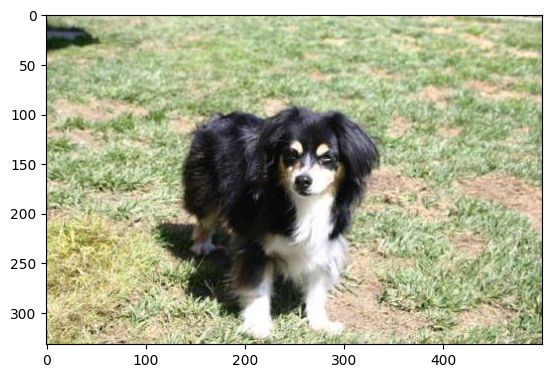

In [31]:
# Draw a cat
# Don't forget to install 'pillow' module (conda install pillow) to give a 'pyplot' ability of working with '.jpg'
img = plt.imread(f'{train_images_path}/{imagenames[1]}')
plt.imshow(img);

Split data on train and validation subsets

In [32]:
# Split data on train and validation subsets
# Using 10% or 20% from train data is classical approach
X_train, X_val = train_test_split(animals, test_size=0.2,  random_state=2)
X_train = X_train.reset_index()
X_val = X_val.reset_index()

# We may want use only 1800 images because of CPU computational reasons. If so, this code should be run
# X_train = X_train.sample(n=1800).reset_index()
# X_val = X_val.sample(n=100).reset_index()

In [33]:
# Count
total_X_train = X_train.shape[0]
total_X_val = X_val.shape[0]

print(total_X_train)
print(total_X_val) 

65
17


CNN Learning

Model 1. VGG16

In [34]:
# By default, the VGG16 model expects images as input with the size 224 x 224 pixels with 3 channels (e.g. color).
image_size = 224
input_shape = (image_size, image_size, 3)

In [35]:
# Define CNN model constants
epochs = 5
batch_size = 16

In [36]:
# Define our pre-trained model
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

I0000 00:00:1771686479.029984  111399 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9233 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [37]:
# Print models summary table
# Note that it expects input pictures in 224 size and 3 channels, as we mensioned before. So we didn't lie.
print(pre_trained_model.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
# Add some micro-tuning 
# Set above layers to be not traianble since using pre-trained model - they are already trained
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

# Specify networks output    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to one dimension
x = GlobalMaxPooling2D()(last_output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Form our model
model_mod = Model(pre_trained_model.input, x)

In [41]:
# Compile model
model_mod.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9), # Changed lr to learning_rate
    metrics=['accuracy']
)

Training DataGenerator

In [42]:
# Implement train ImageDataGenerator and specify some small preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [44]:
# Upload images from file system using flow_from_dataframe() method and use our datagen
# to make parallel preprocessing. We obtain uploaded and preprocessed images.
train_generator = train_datagen.flow_from_dataframe(
    X_train, 
    train_images_path,
    x_col='Image name',
    y_col='Category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    #validate_filenames = False
)

Found 65 validated image filenames belonging to 2 classes.


Validation DataGenerator

In [46]:
# Implement validation ImageDataGenerator
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [47]:
# Upload and peprocess images
validation_generator = validation_datagen.flow_from_dataframe(
    X_val, 
    train_images_path,
    x_col='Image name',
    y_col='Category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    #validate_filenames = False
)

Found 17 validated image filenames belonging to 2 classes.


In [49]:
# Check one sample generated image
# Create generator for test sample image
generated_example_df = X_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    generated_example_df, 
    train_images_path, 
    x_col='Image name',
    y_col='Category',
    class_mode='categorical',
    #validate_filenames = False
)

Found 1 validated image filenames belonging to 1 classes.


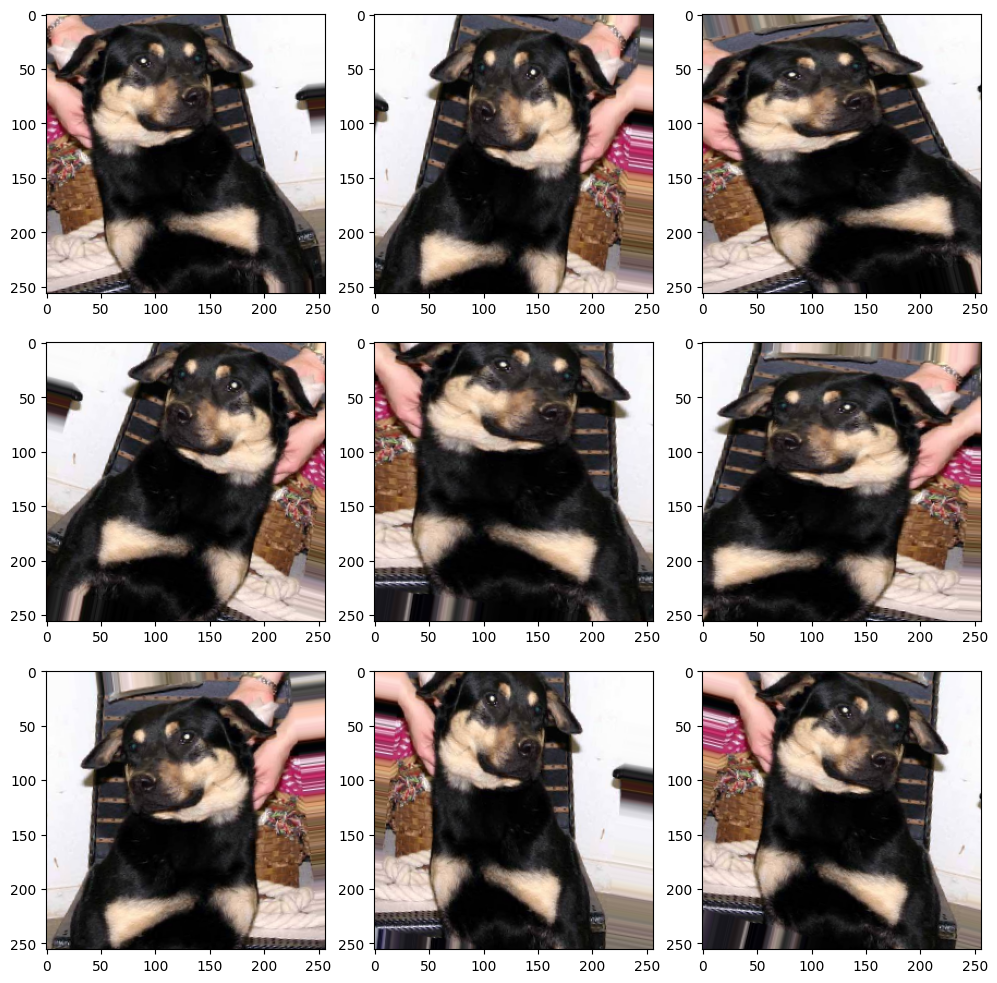

In [50]:
# Plot sample
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Early Stop¶

In [51]:
earlystop = EarlyStopping(patience=10, 
                          verbose=1, 
                          mode='auto'
                         )


In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001
                                           )


In [53]:
# Save our callbacks
callbacks = [earlystop, learning_rate_reduction]

In [54]:
callbacks

Model fit

In [ ]:
# Fit the model

history = model_mod.fit(
    train_generator,
    steps_per_epoch=total_X_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_X_val // batch_size,
    callbacks=callbacks
)

2026/02/21 20:45:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8230a0097cab45c881b24507d773ebce', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2026/02/21 20:45:58 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2026/02/21 20:45:58 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/5


: 